# Libraries

In [1]:
from datetime import datetime, timedelta
import os
import altair as alt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from umap import UMAP

C:\Users\klapc6\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and prepare data

In [4]:
user_df = pd.read_csv("https://storage.googleapis.com/superlinked-notebook-user-acquisiton-analytics/user_acquisiton_data.csv")

In [5]:
user_df.shape
user_df.head()

,id,signup_date,ad_creative,activity
0,0,1693044869,Join a dynamic gaming universe where every cha...,0.295882
1,1,1694581577,Join a thriving gaming community and challenge...,1.138306
2,2,1693557423,Experience the rush of competitive gaming! Joi...,0.005266
3,3,1693313203,Experience the rush of competitive gaming! Joi...,0.297846
4,4,1692863645,Join a dynamic gaming universe where every cha...,0.118947


Signup date is a timestamp. I thought about changeing it to date but for clustering this form should be better (we basically calculate distances for which a numeric variable is better). 

## Vectorize text

I haven't done this before, if it is utter bullshit I am deeply sorry. I will use the sbert package with the recommended "all-mpnet-base-v2" model. It should be the best for general purposes, however it might be very slow. If it is too slow indeed, will use "all-MiniLM-L6-v2" instead.
As i see there are 12 versions of ad_creative. The easiest would be to treat this as a simple categorical variable and use some encoding from the previous class. But vectorization sounds more fun.

In [6]:
user_df["ad_creative"].value_counts()

ad_creative
Unleash your gaming potential! Upgrade to premium for 2 months free and dominate the competition with XYZCr$$d!                                                  1785
Ready to level up? Join XYZCr$$d now for intense gaming battles and exclusive rewards!                                                                           1312
Embark on your gaming journey with XYZCr$$d! Join now and experience the thrill of competing against the finest players worldwide!                                715
Join a dynamic gaming universe where every challenge pushes your skills to the limit! Connect with like-minded gamers and conquer the virtual realm together!     671
Step into the arena of endless possibilities! Join now to engage in exhilarating gaming competitions and forge friendships with fellow gamers along the way!      541
Calling all gamers! Don't miss out on your chance to excel. Join XYZCr$$d today for unparalleled gaming excitement and endless challenges!                    

### Dummy example from sbert homepage:

In [7]:

model = SentenceTransformer("all-MiniLM-L6-v2")

# Our sentences to encode
sentences = [
    "This framework generates embeddings for each input sentence",
    "Sentences are passed as a list of string.",
    "The quick brown fox jumps over the lazy dog."
]

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173459e-02 -4.28515188e-02 -1.56286024e-02  1.40537797e-02
  3.95537801e-02  1.21796258e-01  2.94333864e-02 -3.17523889e-02
  3.54959629e-02 -7.93139860e-02  1.75878592e-02 -4.04370055e-02
  4.97259274e-02  2.54912041e-02 -7.18700588e-02  8.14968869e-02
  1.47070049e-03  4.79627140e-02 -4.50336300e-02 -9.92174819e-02
 -2.81769671e-02  6.45046532e-02  4.44670469e-02 -4.76217121e-02
 -3.52952629e-02  4.38671932e-02 -5.28565831e-02  4.33033478e-04
  1.01921469e-01  1.64072085e-02  3.26996446e-02 -3.45986821e-02
  1.21339206e-02  7.94871151e-02  4.58346587e-03  1.57778263e-02
 -9.68205091e-03  2.87625752e-02 -5.05806208e-02 -1.55793773e-02
 -2.87906546e-02 -9.62282810e-03  3.15556638e-02  2.27348655e-02
  8.71449336e-02 -3.85027416e-02 -8.84718597e-02 -8.75498541e-03
 -2.12342888e-02  2.08923370e-02 -9.02077407e-02 -5.25732227e-02
 -1.05638960e-02  2.88310722e-02 -1.61454901e-02  6.17840327e-03
 -1.23234

In [8]:
len(embeddings[2])
# This specific model creates a 384 dimensional representation from these sentences

384

### Use own data

In [9]:
model = SentenceTransformer("all-mpnet-base-v2")
# Tensorization was recommended by chatgpt
embeddings = model.encode(user_df["ad_creative"],convert_to_tensor=True)

In [10]:
len(embeddings[6])
# This creates a 768 dimensional space

768

In [45]:
# As I understand all these would become features for the clustering. The superlinked version did not work for me, so i try to do it without it.
embeddings[0][0:10]

tensor([-0.0067, -0.0046, -0.0368,  0.0128, -0.0089, -0.0046, -0.0696,  0.0023,
        -0.0153,  0.0532])

In [12]:
user_df.columns

Index(['id', 'signup_date', 'ad_creative', 'activity'], dtype='object')

In [13]:
# This was also recommended by chatgpt (and we also talked about it in class), 
# that the features should have similar similar scaling. My worry is that each sentence from the original data 
# now has more than 700 features, that makes them more "important" relative to the other 2 features in the clustering
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)
scaled_features = scaler.fit_transform(user_df[["signup_date","activity"]].values)


In [46]:
#Whatever :D
scaled_features[0:10]

array([[-1.77405203, -0.05029302],
       [-1.44592907,  3.10656403],
       [-1.66460981, -1.13933192],
       [-1.71675647, -0.04293266],
       [-1.81274758, -0.71332818],
       [-1.81275142, -0.0884563 ],
       [-1.82692531, -0.43524416],
       [-1.57492469, -0.39881167],
       [-1.71596366, -0.47895741],
       [-1.67565046,  0.04463215]])

In [15]:
check_inverse = scaler.inverse_transform(scaled_features)
check_inverse[0]

array([1.69304487e+09, 2.95881631e-01])

In [16]:
user_df.iloc[0]
#Scaling looks ok for the date and activity features (i still don't care that date is a timestamp, maybe I should)

id                                                             0
signup_date                                           1693044869
ad_creative    Join a dynamic gaming universe where every cha...
activity                                                0.295882
Name: 0, dtype: object

In [17]:
# Data for clustering:
scaled_data = pd.concat([pd.DataFrame(scaled_features),pd.DataFrame(scaled_embeddings)],axis=1)
scaled_data.shape

(8000, 770)

# Clustering

## DBSCAN:

In [18]:
dbscan = DBSCAN(eps=0.5, min_samples=4)
clusters = dbscan.fit_predict(scaled_data)

In [19]:
# With baseline parameters dbscan found 25 clusters - a bit too many (we had 12 sentences).
# Probably too many central nodes with min_samples = 4. 
clusters.max()

23

In [20]:
# With arbitrary 400 as min_samples we get 5 clusters which feels better (and is closer to the one in the Mór's notebook)
dbscan = DBSCAN(eps=0.5, min_samples=400)
db_clusters = dbscan.fit_predict(scaled_data)
db_clusters.max()


3

## HDBSCAN:

In [21]:
hdbscan = HDBSCAN(min_cluster_size=400,min_samples=15)
hdb_clusters = hdbscan.fit_predict(scaled_data)
hdb_clusters.max()

8

In [22]:
user_df["db_cluster"] = db_clusters
user_df["hdb_cluster"] = hdb_clusters

In [23]:

user_df["db_cluster"].value_counts()

db_cluster
-1    4484
 0    1439
 2    1070
 1     592
 3     415
Name: count, dtype: int64

In [24]:
user_df["hdb_cluster"].value_counts()

hdb_cluster
 4    1785
 8    1312
 7    1014
 1     844
 5     671
 6     541
 2     533
 3     501
 0     452
-1     347
Name: count, dtype: int64

# Dimension Reduction and ploting

In [25]:
umap_fit = UMAP(random_state=0, transform_seed=0, n_jobs=1, n_neighbors=10,min_dist= 0.1)
umap_data = umap_fit.fit_transform(scaled_data)
umap_data = pd.DataFrame(umap_data,columns= ["dim1","dim2"])
umap_data["db_cluster"] = user_df["db_cluster"]
umap_data["hdb_cluster"] = user_df["hdb_cluster"]

C:\Users\klapc6\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [26]:
umap_data.shape

(8000, 4)

In [27]:
# Altair visualization code was copied from Mór's code basically without any changes
alt.renderers.enable("mimetype")
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [41]:
db_cluster_plot = alt.Chart(umap_data).mark_circle(size=10).encode(
    x="dim1", y="dim2", color="db_cluster:N"
).properties(
    width=600, height=500, title="UMAP Transformed vectors coloured by dbscan cluster labels"
)

In [42]:
hdb_cluster_plot = alt.Chart(umap_data).mark_circle(size=10).encode(
    x="dim1", y="dim2", color="hdb_cluster:N"
).properties(
    width=600, height=500, title="UMAP Transformed vectors coloured by hdbscan cluster labels"
)

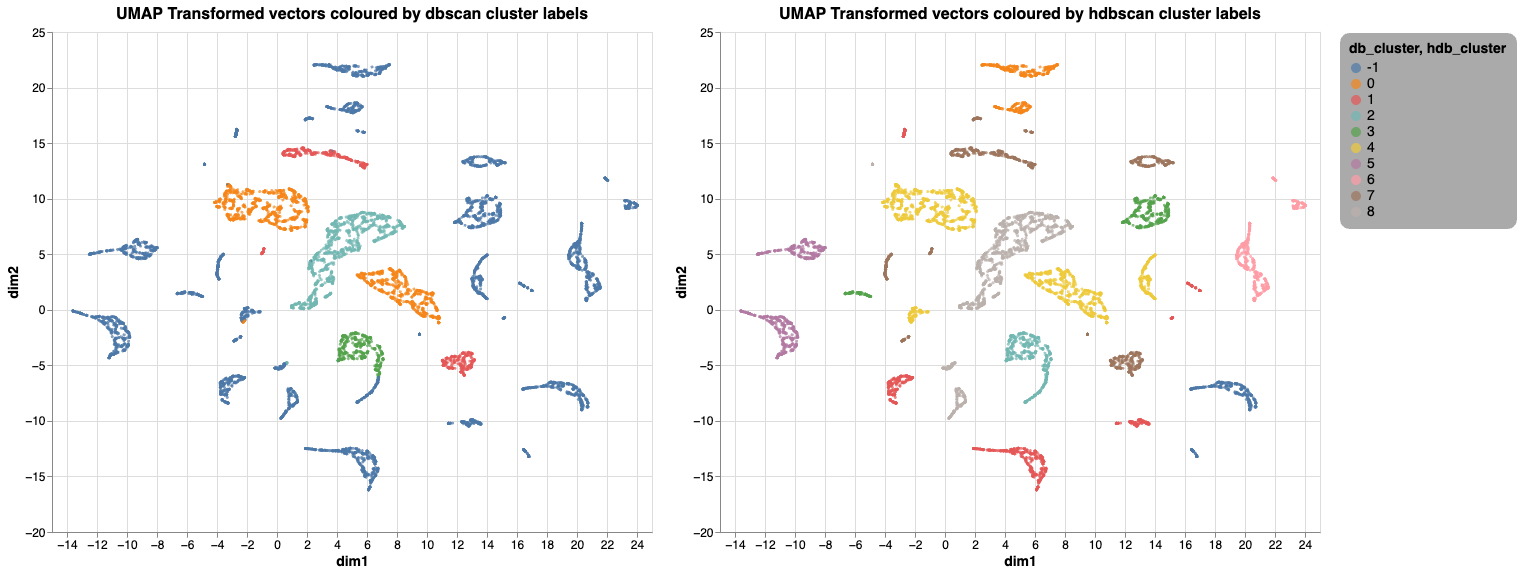

In [44]:
alt.hconcat(db_cluster_plot,hdb_cluster_plot).configure_title(
    fontSize=16,
    anchor="middle",
).configure_legend(
    strokeColor="white",
    fillColor="#AAAAAA",
    padding=10,
    cornerRadius=10,
    labelFontSize=14,
    titleFontSize=14,
).configure_axis(
    titleFontSize=14, labelFontSize=12
)

Annyit még biztosan lehetne ezen javítani, hogy a klaszterezés paraméterei ne az én jóérzésemtől, hanem valamin alapuló érvektől függjenek. 